In [164]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Introduction

The Fashion MNIST dataset is a collection of 70,000 grayscale pre-labeled images depicting various clothing items. Each image belongs to one of 10 categories, such as t-shirt, trouser, or dress. Inspired by the traditional MNIST dataset of handwritten digits, Fashion MNIST posts a more challenging classification problem for researchers and students studying machine learning algorithms since Fashion MNIST include categories with strikingly similar appearance such as sneaker and ankle boot.

Speaking of the classification problem, supervised learning algorithms are probably thought to be the most common approach. It is true that some supervised learning algorithms can achieve high accruacy in image classification given a large, diverse enough dataset. In this study, we will show that beyond clustering, an unsupervised learning algorithm can also be used to sort out the images. The major difference between clustering and classification is that clustering can work with unlabeled data, while classification only works with labeled data. This implies that clustering methods can be applied to the classification problem by manually corresponding the cluster labels to category labels using a dictionary.Since the clustering method does not retain knowledge of the train data when working on clustering the test data, it is not using any previous knowledge for prediction. That said, hyperparameter tuning on accuracy using the train data helps us pin down the near optimal number of clusters for the test data.

In this study, we also implement data augmentation by shifting the image arrays by one pixel while their respective categories remain the same. Data augmentation is a regularization technique which aims to avoid overfitting through reducing the data variance by adding more prior knowledge at the cost of increasing bias. We will show that after data augmentation, given the same number of clusters, the accuracy score on the train data will not improved as expected while that of the test data will only improved for the supervised learning algorithm as the clustering method can not retain the knowledge of train data for better generalization.Thus, we conclude that although an unsupervised learning algorithm may be used to work on classification, its accuracy result is nowhere as good as the supervised counterparts.

In [165]:
import numpy as np
import pandas as pd

In [166]:
from time import time


In [167]:
# Importing the dataset from keras
from keras.datasets import mnist
from keras.datasets import fashion_mnist

tL0 = time()

#(x_train, y_train), (x_test, y_test) = mnist.load_data()
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

tL1 = time()

print('Data Loading time {}'.format(tL1-tL0))

Data Loading time 0.41972947120666504


In [168]:
print(x_train.shape,x_test.shape)

(60000, 28, 28) (10000, 28, 28)


In [169]:
import matplotlib.pyplot as plt

<Figure size 640x480 with 0 Axes>

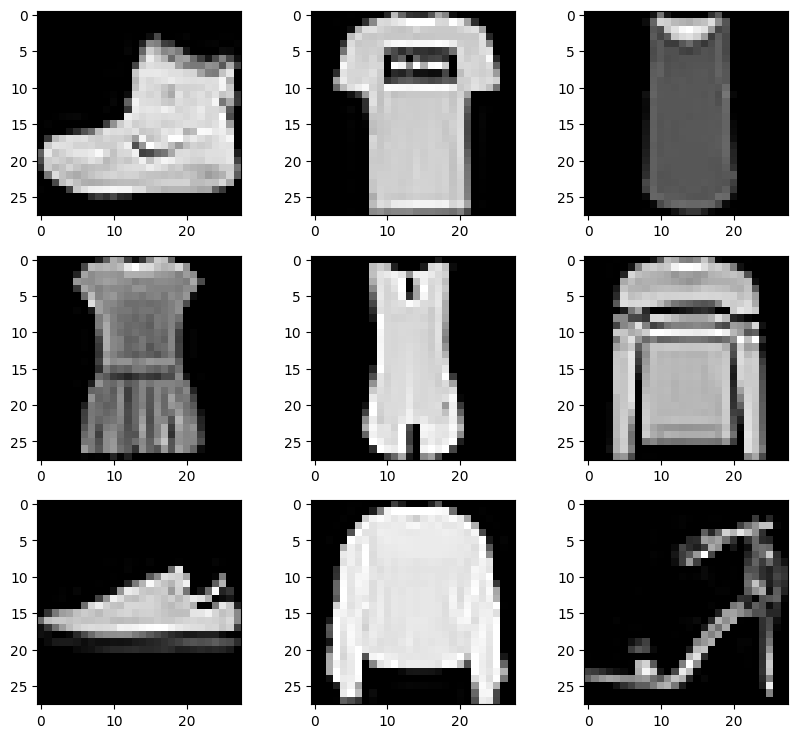

In [170]:
plt.gray() # B/W Images
plt.figure(figsize = (10,9)) # Adjusting figure size
# Displaying a grid of 3x3 images
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(x_train[i])

In [171]:
# Printing examples in 'y_train'
#for i in range(9):
#    print(y_train[i],)
mylist = list(y_train[0:9])
print(*mylist, sep=' ') 

9 0 0 3 0 2 7 2 5


In [172]:
# Checking the minimum and maximum values of x_train
#print(x_train.min())
#print(x_train.max())
x_train_scale = x_train.max() - x_train.min()

In [173]:
# Data Normalization
# Conversion to float
x_train = x_train.astype('float32') 
x_test = x_test.astype('float32')
# Normalization
x_train = x_train/x_train_scale
x_test = x_test/x_train_scale

In [174]:
# Checking the minimum and maximum values of x_train
print(x_train.min())
print(x_train.max())

0.0
1.0


In [175]:
# Reshaping input data
X_train = x_train.reshape(len(x_train),-1)
X_test = x_test.reshape(len(x_test),-1)

In [176]:
# Checking the shape
print(X_train.shape)
print(X_test.shape)

(60000, 784)
(10000, 784)


# Comparison with a supervised counterpart

A supervised algorithm, Random Forest Classifier (RFC), is chosen as the bench mark since it excels at handling a high number of features, is robust to outliers and is less prone to overfitting. In addition, RFC can be easily parallelized to speed up the training process.

In [177]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

tRF0 = time()

rfc = RandomForestClassifier(n_estimators=10)
rfc.fit(X_train,y_train)


tRF1 = time()

print('Random Forest Training time {}'.format(tRF1-tRF0))

acc_rfc = accuracy_score(y_test, rfc.predict(X_test))
acc_rfc



Random Forest Training time 12.298182010650635


0.8524

# Mini-Batch K-Means Clustering

K-Means clustering is chosen instead of the more sophisticated DBSCAN since KMeans only needs the number of clusters to be specified, while DBSCAN would require both Epsilon (the maximum distance between points to be considered neighbors) and MinPts (the minimum number of neighbors a point needs to be considered a core point) to be specified. DBSCAN also faces a difficulty clustering subject to varying densities.

The original K-Means clustering is replaced by Mini-Batch K-Means clustering as the K-Means would slow down by larger datasets. Mini-Batch variation of K-Means clustering could substantially speed up the clustering while retaining a similar accuracy score given the same number of clusters. Mini-Batch K-Means clustering would be applied on behalf of K-Means clustering throughout this study.

In [178]:
from sklearn.cluster import MiniBatchKMeans
total_clusters = len(np.unique(y_test))
# Initialize the K-Means model
kmeans = MiniBatchKMeans(n_clusters = total_clusters)
# Fitting the model to training set
kmeans.fit(X_train)

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


MiniBatchKMeans(n_clusters=10)

In [179]:
kmeans.labels_

array([6, 9, 3, ..., 2, 3, 8], dtype=int32)

In [180]:
print(len(kmeans.labels_),len(np.unique(kmeans.labels_)))

60000 10


In [181]:
# Cluster centroids is stored in ‘centroids’
centroids = kmeans.cluster_centers_

In [182]:
centroids.shape

(10, 784)

# Centroid Examination for accuracy

When the number of clusters/centroids is slow, the centroids may not be able to encompass all the classes in the dataset, resulting in low accuracy.

In [183]:
centroids = centroids.reshape(10,28,28)

In [184]:
centroids = centroids * 255

In [185]:
def label_mapping(cluster_labels,y_input):
    # Dictionary which maps the most frequently occurring cluster_labels to the class_labels
    class_labels = {}
    for i in set(kmeans.labels_):
        class_labels[i] =  np.bincount(y_input[cluster_labels == i]).argmax()
    return class_labels

In [186]:
class_labels = label_mapping(kmeans.labels_,y_train)
print(class_labels)
# Vectorize dictionary mapping
number_labels = np.array(list(map(class_labels.get,kmeans.labels_)))

{0: 8, 1: 4, 2: 3, 3: 0, 4: 7, 5: 1, 6: 9, 7: 2, 8: 5, 9: 0}


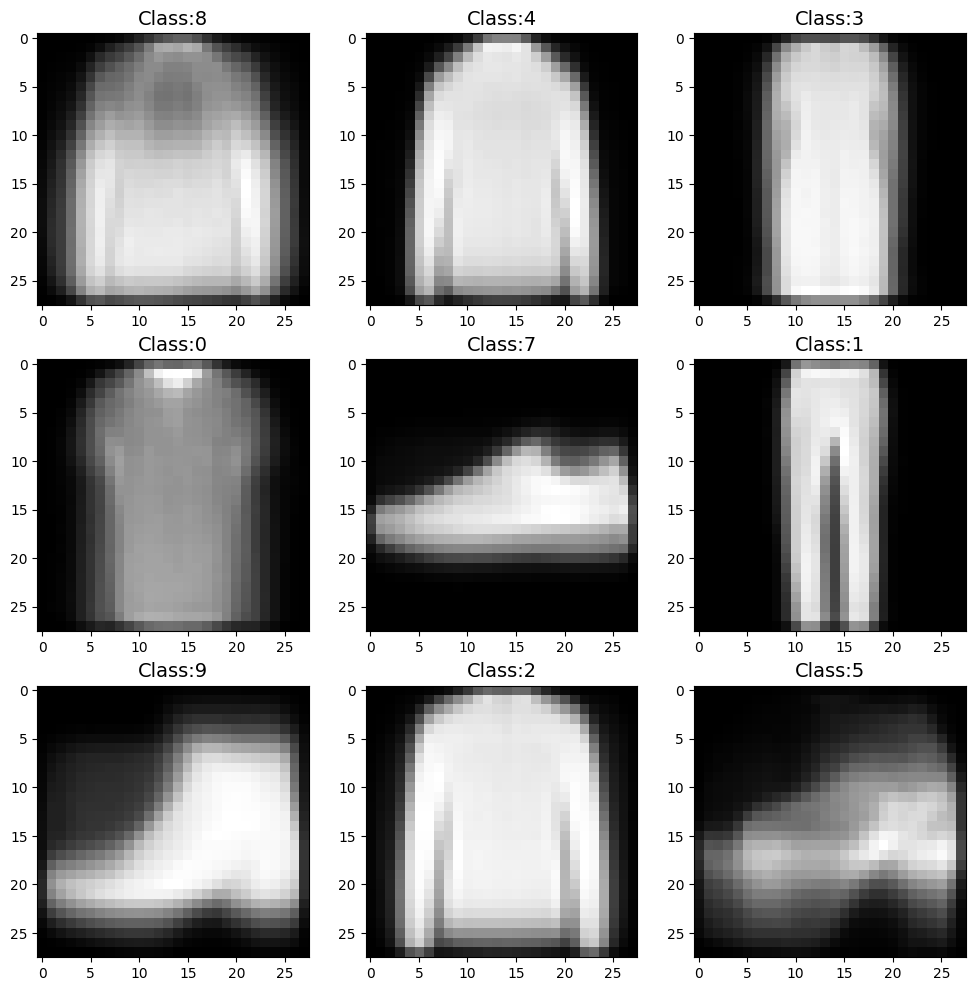

In [187]:
plt.figure(figsize = (12,12))

for i in range(9):
    plt.subplot(3,3,i+1)
    plt.title('Class:{}'.format(class_labels[i]),fontsize = 14)
    plt.imshow(centroids[i])

In [188]:
# Comparing Predicted values and Actual values
print(number_labels[:20].astype('int'))
print(y_train[:20])

[9 0 0 0 3 2 7 2 5 5 0 8 5 5 7 9 1 0 2 0]
[9 0 0 3 0 2 7 2 5 5 0 9 5 5 7 9 1 0 6 4]


In [189]:
# Calculating accuracy score
#from sklearn.metrics import accuracy_score
print(accuracy_score(number_labels,y_train))

0.5781666666666667


In [190]:
# Function to calculate metrics for the model
#def calculate_metrics(model,output):
    #print('Number of clusters is {}'.format(model.n_clusters))
    #print('Inertia : {}'.format(model.inertia_))
    #print('Homogeneity :       {}'.format(metrics.homogeneity_score(output,model.labels_)))

# Hyperparameter Tuning

When we increase the number of clusters, we will observe improvements on the trainihg accuracy. However, the number of clusters can not be infinitely increase since the samples within each of the clusters would be too few to assign a class. The most proper number of clusters would be the convergent one with the highest accuracy.

In [191]:
from sklearn import metrics

cluster_number = [10,50,100,500]
total_clusters = len(np.unique(y_test))
for c in cluster_number:
    kmeans = MiniBatchKMeans(n_clusters = c)
    
    kmeans.fit(X_train)
    
    print('Number of clusters is {}'.format(kmeans.n_clusters))
    # Calculating class_labels
    class_labels = label_mapping(kmeans.labels_,y_train)
    # Vectorize dictionary mapping
    number_labels = np.array(list(map(class_labels.get,kmeans.labels_)))
 
    print('Accuracy score : {}'.format(accuracy_score(number_labels,y_train)))
    print('\n')

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Number of clusters is 10
Accuracy score : 0.51165




/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Number of clusters is 50
Accuracy score : 0.6973833333333334




/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Number of clusters is 100
Accuracy score : 0.74155




/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Number of clusters is 500
Accuracy score : 0.7970333333333334




# Test data application

Accuracy on test data is approximately as high as that of the train data if not substantially higher.

In [192]:
kmeans = MiniBatchKMeans(n_clusters = 500)
kmeans.fit(X_test)

class_labels = label_mapping(kmeans.labels_,y_test)


# Vectorize dictionary mapping
number_labels = np.array(list(map(class_labels.get,kmeans.labels_)))

print('Accuracy score : {}'.format(accuracy_score(number_labels,y_test)))
print('\n')


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Accuracy score : 0.788




In [193]:
# Cluster centroids is stored in ‘centroids’
centroids = kmeans.cluster_centers_

In [194]:
centroids.shape

(500, 784)

In [195]:
centroids = centroids.reshape(500,28,28)

In [196]:
centroids = centroids * 255

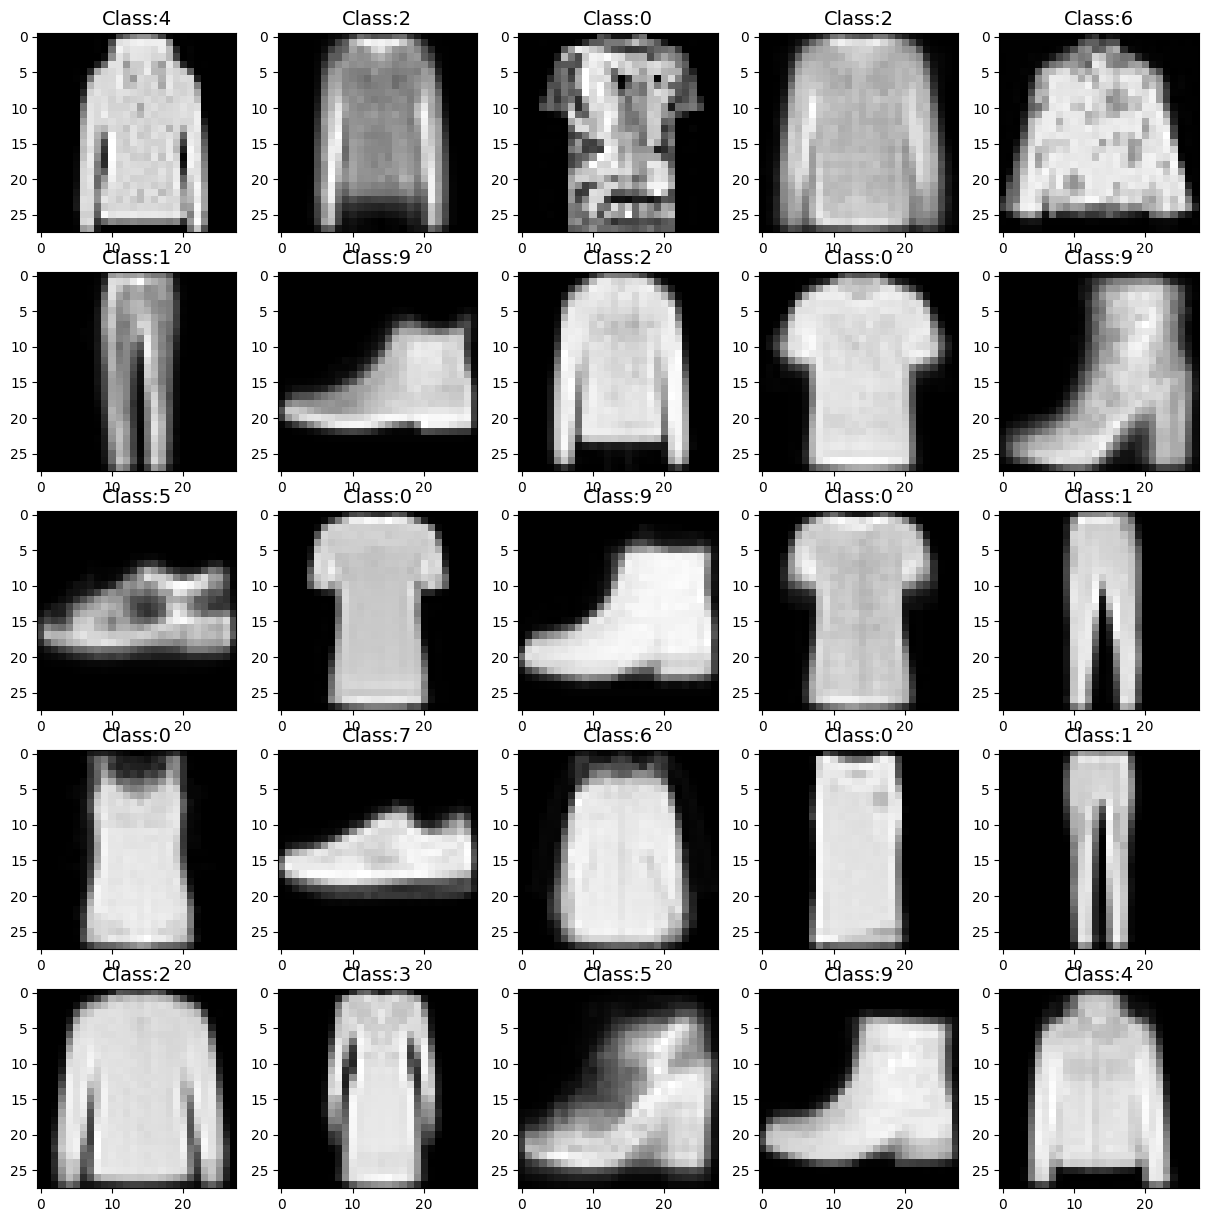

In [197]:
plt.figure(figsize = (15,15))

for i in range(25):
    plt.subplot(5,5,i+1)
    plt.title('Class:{}'.format(class_labels[i]),fontsize = 14)
    plt.imshow(centroids[i])

# Data Augmentation

Image rotation does not provide good data generalization as the fashion images are senstive to direction. Instead, we shift the images by one pixel for all 4 directions while remaining the same class. This would be an effective data augmentation although it marginally improves the prediction accuracy of RFC while making the clustering method harder to sort things out. The more the merrier does not apply to the unsupervised learning. Thus, the clustering accuracy actually declines slightly after data augmentation.

In [198]:
#from cv2 import rotate
#from PIL import Image
#x_train_aug = []
#for t in range(1,4):
#    x_train_aug += [np.rot90(img,t) for img in x_train]
#x_train_aug = np.array(x_train_aug)

In [199]:
#x_train2 = np.concatenate((x_train, x_train_aug), axis=0)

In [200]:
from scipy.ndimage import shift

In [201]:
# Method to shift the image by given dimension
def shift_image(image, dx, dy):
    image = image.reshape((28, 28))
    shifted_image = shift(image, [dy, dx], cval=0, mode="constant")
    return shifted_image

In [202]:
# Creating Augmented Dataset
#x_train2 = [image for image in x_train]
xl_train2 = list(x_train.copy())

for dx, dy in ((1,0), (-1,0), (0,1), (0,-1)):
    for image in x_train:
        xl_train2.append(shift_image(image, dx, dy))

In [203]:
x_train2 = np.dstack(xl_train2)

In [204]:
x_train2.shape

(28, 28, 300000)

In [205]:
x_train2 = np.rollaxis(x_train2,-1)

In [206]:
X_train2 = x_train2.reshape(len(x_train2),-1)

In [207]:
y_train2 = np.tile(y_train, 5)

Repeat the train labels 5 times likewise

In [208]:
y_train2.shape

(300000,)

In [209]:
tRF0 = time()

rfc2 = RandomForestClassifier(n_estimators=10)
rfc2.fit(X_train2,y_train2)


tRF1 = time()

print('Random Forest Training time {}'.format(tRF1-tRF0))


Random Forest Training time 127.36608242988586


In [210]:
acc_rfc2 = accuracy_score(y_test, rfc2.predict(X_test))
acc_rfc2

0.8644

In [211]:
kmeans = MiniBatchKMeans(n_clusters = 500)

kmeans.fit(X_train2)

class_labels = label_mapping(kmeans.labels_,y_train2)

# Vectorize dictionary mapping
number_labels = np.array(list(map(class_labels.get,kmeans.labels_)))

print('Accuracy score : {}'.format(accuracy_score(number_labels,y_train2)))

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Accuracy score : 0.7617466666666667


# Conclusion

The Mini-Batch K-Means clustering was tested in this study. While its accuracy is nowhere as good as the RFC, it demonstrated the potential of the unsupervised learning methods for classification purposes. After all, the Fashion MNIST dataset is compact but challenging to begin with. By increasing the number of clusters, accuracy score was substantially improved. We also tested the data augmentation technique on this specific dataset to observe it would not help with the accuracy of the Mini-Batch K-Means. That said, this study poses as a great stepping stone for the future study on the unsupervised learning algorithms.